In [86]:
from ConvNet import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5555204590400335072]

## I. Basic operation with tensorFlow

In [3]:
tf.reset_default_graph()

#setup
x = tf.constant(1.,name="input_value")
w = tf.Variable(0.8, name="weight")
y = tf.multiply(w , x, name="output_value")
y_ = tf.constant(0.0)
loss = (y - y_)**2

#Print graph
# monitor_operation()

#Optimizer
train_step = tf.train.GradientDescentOptimizer(0.025).minimize(loss)

#Summary
tf.summary.scalar('ouput', y)
tf.summary.scalar("loss", loss)
merged_summary_op = tf.summary.merge_all()


with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter('log_test-graph')
    summary_writer.add_graph(sess.graph)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(100):
        summary_str = sess.run(merged_summary_op)
        summary_writer.add_summary(summary_str, i)
        sess.run(train_step)

**Acces to the tensorboard:**  
*python -m tensorboard.main --logdir=log_test-graph*  
then go to *http://localhost:6006*

## II. Dataset

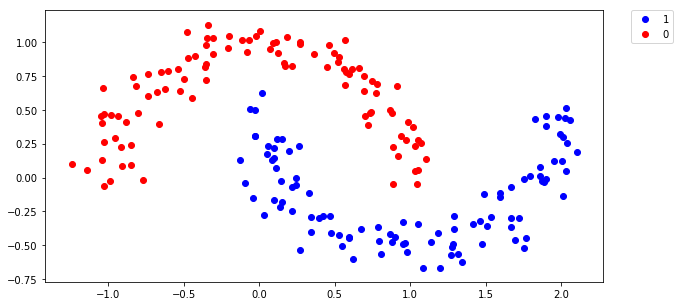

In [4]:
select='moon' # 'blob' or 'moon'
if select == 'moon':
    from sklearn.datasets import make_moons
    X_ori, y_ori = make_moons(n_samples=200, noise=0.1)
elif select == 'blob':
    from sklearn.datasets.samples_generator import make_blobs
    np.random.seed(1)
    X_ori, y_ori = make_blobs(n_samples=200, centers=2, n_features=2)
elif select == 'circle':
    from sklearn.datasets.samples_generator import make_circles
    X_ori, y_ori = make_circles(n_samples=200, noise=0.05)


plt.figure(figsize=(10,5))
plt.scatter(*zip(*X_ori[y_ori==1]), c= 'b', label = '1')
plt.scatter(*zip(*X_ori[y_ori==0]), c= 'r', label = '0')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [5]:
X = X_ori.T
idx=np.random.permutation(X.shape[1])
y=y_ori.reshape(-1,1).T
X_train, X_test = X[:,idx[:int(X.shape[1]*0.8)]], X[:,idx[int(X.shape[1]*0.8):]]
y_train, y_test = y[:,idx[:int(X.shape[1]*0.8)]], y[:,idx[int(X.shape[1]*0.8):]]

## II. Fully Connected Network

In [6]:
tf.reset_default_graph()
model=Fully_Connected(X_train, y_train, X_test, y_test)
model.add_FC(20)
model.add_FC(10)
model.add_FC(10)
model.add_FC(10)
model.train(epoch = 2001 , batch_size = 32,lr = 1e-4, filename = 'log_graph_test3')

AttributeError: 'Fully_Connected' object has no attribute 'loss'

In [ ]:
tf.reset_default_graph()
model=Fully_Connected(X_train, y_train, X_test, y_test)
model.add_FC(10)
model.train(epoch = 2001 , batch_size = 32,lr = 1e-4, filename = 'log_graph_test4/mod1')

In [120]:
tf.reset_default_graph()
model=Fully_Connected(X_train, y_train, X_test, y_test)
model.add_FC(20)
model.add_FC(10)
model.compile()
model.train(epoch = 2001 , batch_size = 32,lr = 1e-4, filename = 'log_graph_test4/mod2')
# model.predict_probs(X_train).shape

epoch 0, training loss 2.93136, test loss 2.90024, test accuracy 0.35
epoch 300, training loss 0.417976, test loss 0.351809, test accuracy 0.825
epoch 600, training loss 0.205901, test loss 0.309532, test accuracy 0.875
epoch 900, training loss 0.146385, test loss 0.225165, test accuracy 0.875
epoch 1200, training loss 0.10192, test loss 0.164439, test accuracy 0.95
epoch 1500, training loss 0.0716502, test loss 0.123208, test accuracy 0.95
epoch 1800, training loss 0.0460478, test loss 0.0855475, test accuracy 0.95


In [65]:
tf.reset_default_graph()
model=Fully_Connected(X_train, y_train, X_test, y_test)
model.add_FC(20)
model.add_FC(10)
model.add_FC(10)
model.add_FC(10)
model.compile()
model.train(epoch = 2001 , batch_size = 32,lr = 1e-4, filename = 'log_graph_test4/mod3')

AttributeError: 'Fully_Connected' object has no attribute 'X'

In [ ]:
tf.reset_default_graph()
X = tf.placeholder(dtype = tf.float32, shape = [2, None], name = 'Input')
Y = tf.placeholder(dtype = tf.float32, shape = [1, None], name = 'Label')
layer_1 = FC_layer(X, 20, 2)
layer_2 = FC_layer(layer_1, 10, 20)
layer_3 = FC_layer(layer_2, 1, 10, 'sigmoid')

#compute loss
with tf.name_scope('Loss'):
    cross_entropy = - tf.reduce_mean(Y * tf.log(layer_3) + (1 - Y) * tf.log(1 - layer_3))


#optimizer
with tf.name_scope('Train'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

#Accuracy
with tf.name_scope('Accuracy'):
    predicted_class = tf.greater(layer_3,0.5)
    correct = tf.equal(predicted_class, tf.equal(Y,1.0))
    accuracy = tf.reduce_mean( tf.cast(correct, 'float') )

tf.summary.scalar('cross_entropy', cross_entropy)
tf.summary.scalar('accuracy', accuracy)

merged_summary = tf.summary.merge_all()


with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter('test-graph6')
    summary_writer.add_graph(sess.graph)
    
    sess.run(tf.global_variables_initializer())
    for i in range(2001):
        sess.run(train_step, feed_dict={X:X_train, Y:y_train})
        if i % 1 ==0:
            s=sess.run(merged_summary, feed_dict={X:X_train, Y:y_train})
            summary_writer.add_summary(s,i)
        if i % 500 == 0:
            train_loss = sess.run(cross_entropy, feed_dict={X:X_train, Y:y_train})
            train_accuracy = sess.run(accuracy, feed_dict={X:X_train, Y:y_train})
            print("step %s, training accuracy %s, loss %s " % (i, train_accuracy, train_loss))

In [77]:
import tensorflow as tf
tf.reset_default_graph()
w = tf.Variable(1.)
x = tf.placeholder(dtype = tf.float32, name = 'input')
y = w * x

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(w.assign(4))
    print(sess.run(y, feed_dict={x : 3}))
    print(w.eval())


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(y, feed_dict={'input:0' : 3}))

tf.summary.scalar('input','input:0')


12.0
4.0
3.0


TypeError: Value passed to parameter 'values' has DataType string not in list of allowed values: float32, float64, int32, int64, uint8, int16, int8, uint16, float16